In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.optimizers.schedules import ExponentialDecay


import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder


import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    


seed_everything(42) # Seed 고정

In [39]:
target = 'ECLO'
light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
child_area_df['시설수'] = 1
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
parking_df.reset_index(inplace=True, drop=True)
parking_df = parking_df.fillna(0)

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
cols = list(test.columns)
cols.append(target)
train = train[cols]

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
train = train.drop(columns=['사고일시'])
test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
test = test.drop(columns=['사고일시'])

location_pattern = r'(\S+) (\S+) (\S+)'
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

road_pattern = r'(.+) - (.+)'
train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train = train.drop(columns=['도로형태'])

test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])

train = train.drop(['연', '월', '일', '시간', 'ID'],axis=1)
test = test.drop(['연', '월', '일', '시간', 'ID'],axis=1)
# train = train.dropna()

train = train.fillna(0)
test = test.fillna(0)

# test_x = test.copy()
# train_x = train[test.columns].copy()
# train_y = train['ECLO'].copy()
categorical_features = list(train.dtypes[train.dtypes == "object"].index)
for i in categorical_features:
    le = TargetEncoder()
    train[i] = le.fit_transform(train[i],train[target])
    test[i] = le.transform(test[i])
    
# minmax_scaler = MinMaxScaler()
# data = minmax_scaler.fit_transform(train.drop('ECLO',axis=1))
# data = pd.DataFrame(data,columns=train.drop('ECLO',axis=1).columns)
# data

Epoch 1/30
Batch 0: Invalid loss, terminating training
   1/1981 [..............................] - ETA: 0s - loss: nan - rmsle: nanBatch 1: Invalid loss, terminating training
Batch 2: Invalid loss, terminating training
Batch 3: Invalid loss, terminating training
Batch 4: Invalid loss, terminating training
Batch 5: Invalid loss, terminating training
Batch 6: Invalid loss, terminating training
Batch 7: Invalid loss, terminating training
Batch 8: Invalid loss, terminating training
Batch 9: Invalid loss, terminating training
Batch 10: Invalid loss, terminating training
Batch 11: Invalid loss, terminating training
Batch 12: Invalid loss, terminating training
Batch 13: Invalid loss, terminating training
Batch 14: Invalid loss, terminating training
Batch 15: Invalid loss, terminating training
Batch 16: Invalid loss, terminating training
Batch 17: Invalid loss, terminating training
Batch 18: Invalid loss, terminating training
Batch 19: Invalid loss, terminating training
Batch 20: Invalid loss

 201/1981 [==>...........................] - ETA: 1s - loss: nan - rmsle: nanBatch 201: Invalid loss, terminating training
Batch 202: Invalid loss, terminating training
Batch 203: Invalid loss, terminating training
Batch 204: Invalid loss, terminating training
Batch 205: Invalid loss, terminating training
Batch 206: Invalid loss, terminating training
Batch 207: Invalid loss, terminating training
Batch 208: Invalid loss, terminating training
Batch 209: Invalid loss, terminating training
Batch 210: Invalid loss, terminating training
Batch 211: Invalid loss, terminating training
Batch 212: Invalid loss, terminating training
Batch 213: Invalid loss, terminating training
Batch 214: Invalid loss, terminating training
Batch 215: Invalid loss, terminating training
Batch 216: Invalid loss, terminating training
Batch 217: Invalid loss, terminating training
Batch 218: Invalid loss, terminating training
Batch 219: Invalid loss, terminating training
Batch 220: Invalid loss, terminating training
Bat

 378/1981 [====>.........................] - ETA: 1s - loss: nan - rmsle: nanBatch 378: Invalid loss, terminating training
Batch 379: Invalid loss, terminating training
Batch 380: Invalid loss, terminating training
Batch 381: Invalid loss, terminating training
Batch 382: Invalid loss, terminating training
Batch 383: Invalid loss, terminating training
Batch 384: Invalid loss, terminating training
Batch 385: Invalid loss, terminating training
Batch 386: Invalid loss, terminating training
Batch 387: Invalid loss, terminating training
Batch 388: Invalid loss, terminating training
Batch 389: Invalid loss, terminating training
Batch 390: Invalid loss, terminating training
Batch 391: Invalid loss, terminating training
Batch 392: Invalid loss, terminating training
Batch 393: Invalid loss, terminating training
Batch 394: Invalid loss, terminating training
Batch 395: Invalid loss, terminating training
Batch 396: Invalid loss, terminating training
Batch 397: Invalid loss, terminating training
Bat

Batch 561: Invalid loss, terminating training
 562/1981 [=======>......................] - ETA: 0s - loss: nan - rmsle: nanBatch 562: Invalid loss, terminating training
Batch 563: Invalid loss, terminating training
Batch 564: Invalid loss, terminating training
Batch 565: Invalid loss, terminating training
Batch 566: Invalid loss, terminating training
Batch 567: Invalid loss, terminating training
Batch 568: Invalid loss, terminating training
Batch 569: Invalid loss, terminating training
Batch 570: Invalid loss, terminating training
Batch 571: Invalid loss, terminating training
Batch 572: Invalid loss, terminating training
Batch 573: Invalid loss, terminating training
Batch 574: Invalid loss, terminating training
Batch 575: Invalid loss, terminating training
Batch 576: Invalid loss, terminating training
Batch 577: Invalid loss, terminating training
Batch 578: Invalid loss, terminating training
Batch 579: Invalid loss, terminating training
Batch 580: Invalid loss, terminating training
Bat

 765/1981 [==========>...................] - ETA: 0s - loss: nan - rmsle: nanBatch 765: Invalid loss, terminating training
Batch 766: Invalid loss, terminating training
Batch 767: Invalid loss, terminating training
Batch 768: Invalid loss, terminating training
Batch 769: Invalid loss, terminating training
Batch 770: Invalid loss, terminating training
Batch 771: Invalid loss, terminating training
Batch 772: Invalid loss, terminating training
Batch 773: Invalid loss, terminating training
Batch 774: Invalid loss, terminating training
Batch 775: Invalid loss, terminating training
Batch 776: Invalid loss, terminating training
Batch 777: Invalid loss, terminating training
Batch 778: Invalid loss, terminating training
Batch 779: Invalid loss, terminating training
Batch 780: Invalid loss, terminating training
Batch 781: Invalid loss, terminating training
Batch 782: Invalid loss, terminating training
Batch 783: Invalid loss, terminating training
Batch 784: Invalid loss, terminating training
Bat

 952/1981 [=============>................] - ETA: 0s - loss: nan - rmsle: nanBatch 952: Invalid loss, terminating training
Batch 953: Invalid loss, terminating training
Batch 954: Invalid loss, terminating training
Batch 955: Invalid loss, terminating training
Batch 956: Invalid loss, terminating training
Batch 957: Invalid loss, terminating training
Batch 958: Invalid loss, terminating training
Batch 959: Invalid loss, terminating training
Batch 960: Invalid loss, terminating training
Batch 961: Invalid loss, terminating training
Batch 962: Invalid loss, terminating training
Batch 963: Invalid loss, terminating training
Batch 964: Invalid loss, terminating training
Batch 965: Invalid loss, terminating training
Batch 966: Invalid loss, terminating training
Batch 967: Invalid loss, terminating training
Batch 968: Invalid loss, terminating training
Batch 969: Invalid loss, terminating training
Batch 970: Invalid loss, terminating training
Batch 971: Invalid loss, terminating training
Bat

1171/1981 [================>.............] - ETA: 0s - loss: nan - rmsle: nanBatch 1171: Invalid loss, terminating training
Batch 1172: Invalid loss, terminating training
Batch 1173: Invalid loss, terminating training
Batch 1174: Invalid loss, terminating training
Batch 1175: Invalid loss, terminating training
Batch 1176: Invalid loss, terminating training
Batch 1177: Invalid loss, terminating training
Batch 1178: Invalid loss, terminating training
Batch 1179: Invalid loss, terminating training
Batch 1180: Invalid loss, terminating training
Batch 1181: Invalid loss, terminating training
Batch 1182: Invalid loss, terminating training
Batch 1183: Invalid loss, terminating training
Batch 1184: Invalid loss, terminating training
Batch 1185: Invalid loss, terminating training
Batch 1186: Invalid loss, terminating training
Batch 1187: Invalid loss, terminating training
Batch 1188: Invalid loss, terminating training
Batch 1189: Invalid loss, terminating training
Batch 1190: Invalid loss, term

Batch 1341: Invalid loss, terminating training
1342/1981 [===================>..........] - ETA: 0s - loss: nan - rmsle: nanBatch 1342: Invalid loss, terminating training
Batch 1343: Invalid loss, terminating training
Batch 1344: Invalid loss, terminating training
Batch 1345: Invalid loss, terminating training
Batch 1346: Invalid loss, terminating training
Batch 1347: Invalid loss, terminating training
Batch 1348: Invalid loss, terminating training
Batch 1349: Invalid loss, terminating training
Batch 1350: Invalid loss, terminating training
Batch 1351: Invalid loss, terminating training
Batch 1352: Invalid loss, terminating training
Batch 1353: Invalid loss, terminating training
Batch 1354: Invalid loss, terminating training
Batch 1355: Invalid loss, terminating training
Batch 1356: Invalid loss, terminating training
Batch 1357: Invalid loss, terminating training
Batch 1358: Invalid loss, terminating training
Batch 1359: Invalid loss, terminating training
Batch 1360: Invalid loss, term

Batch 1528: Invalid loss, terminating training
Batch 1529: Invalid loss, terminating training
Batch 1530: Invalid loss, terminating training
1531/1981 [======================>.......] - ETA: 0s - loss: nan - rmsle: nanBatch 1531: Invalid loss, terminating training
Batch 1532: Invalid loss, terminating training
Batch 1533: Invalid loss, terminating training
Batch 1534: Invalid loss, terminating training
Batch 1535: Invalid loss, terminating training
Batch 1536: Invalid loss, terminating training
Batch 1537: Invalid loss, terminating training
Batch 1538: Invalid loss, terminating training
Batch 1539: Invalid loss, terminating training
Batch 1540: Invalid loss, terminating training
Batch 1541: Invalid loss, terminating training
Batch 1542: Invalid loss, terminating training
Batch 1543: Invalid loss, terminating training
Batch 1544: Invalid loss, terminating training
Batch 1545: Invalid loss, terminating training
Batch 1546: Invalid loss, terminating training
Batch 1547: Invalid loss, term

1724/1981 [=========================>....] - ETA: 0s - loss: nan - rmsle: nanBatch 1724: Invalid loss, terminating training
Batch 1725: Invalid loss, terminating training
Batch 1726: Invalid loss, terminating training
Batch 1727: Invalid loss, terminating training
Batch 1728: Invalid loss, terminating training
Batch 1729: Invalid loss, terminating training
Batch 1730: Invalid loss, terminating training
Batch 1731: Invalid loss, terminating training
Batch 1732: Invalid loss, terminating training
Batch 1733: Invalid loss, terminating training
Batch 1734: Invalid loss, terminating training
Batch 1735: Invalid loss, terminating training
Batch 1736: Invalid loss, terminating training
Batch 1737: Invalid loss, terminating training
Batch 1738: Invalid loss, terminating training
Batch 1739: Invalid loss, terminating training
Batch 1740: Invalid loss, terminating training
Batch 1741: Invalid loss, terminating training
Batch 1742: Invalid loss, terminating training
Batch 1743: Invalid loss, term

1903/1981 [===========================>..] - ETA: 0s - loss: nan - rmsle: nanBatch 1903: Invalid loss, terminating training
Batch 1904: Invalid loss, terminating training
Batch 1905: Invalid loss, terminating training
Batch 1906: Invalid loss, terminating training
Batch 1907: Invalid loss, terminating training
Batch 1908: Invalid loss, terminating training
Batch 1909: Invalid loss, terminating training
Batch 1910: Invalid loss, terminating training
Batch 1911: Invalid loss, terminating training
Batch 1912: Invalid loss, terminating training
Batch 1913: Invalid loss, terminating training
Batch 1914: Invalid loss, terminating training
Batch 1915: Invalid loss, terminating training
Batch 1916: Invalid loss, terminating training
Batch 1917: Invalid loss, terminating training
Batch 1918: Invalid loss, terminating training
Batch 1919: Invalid loss, terminating training
Batch 1920: Invalid loss, terminating training
Batch 1921: Invalid loss, terminating training
Batch 1922: Invalid loss, term

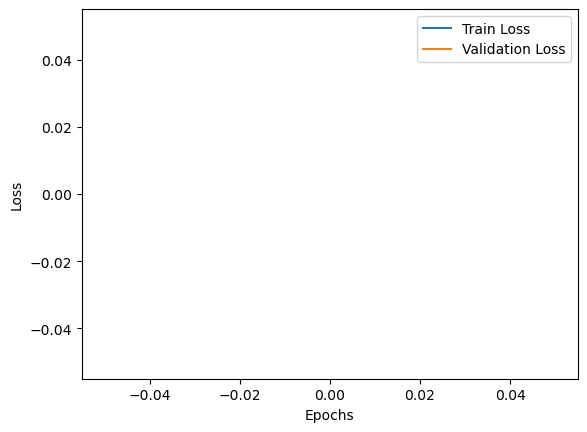

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:60                                                                                   │
│                                                                                                  │
│   57                                                                                             │
│   58 # 모델 평가                                                                                 │
│   59 y_pred = model.predict(X_test)                                                              │
│ ❱ 60 mae = mean_absolute_error(y_test, y_pred)                                                   │
│   61 rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_pred))                               │
│   62 print(f'RMSLE on Test Data: {rmsle_score}')                                                 │
│   63                                                                                             │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_regression.py:196 in     │
│ mean_absolute_error                                                                              │
│                                                                                                  │
│    193 │   >>> mean_absolute_error(y_true, y_pred, multioutput=[0.3, 0.7])                       │
│    194 │   0.85...                                                                               │
│    195 │   """                                                                                   │
│ ❱  196 │   y_type, y_true, y_pred, multioutput = _check_reg_targets(                             │
│    197 │   │   y_true, y_pred, multioutput                                                       │
│    198 │   )                                                                                     │
│    199 │   check_consistent_length(y_true, y_pred, sample_weight)                                │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_regression.py:102 in     │
│ _check_reg_targets                                                                               │
│                                                                                                  │
│     99 │   """                                                                                   │
│    100 │   check_consistent_length(y_true, y_pred)                                               │
│    101 │   y_true = check_array(y_true, ensure_2d=False, dtype=dtype)                            │
│ ❱  102 │   y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)                            │
│    103 │                                                                                         │
│    104 │   if y_true.ndim == 1:                                                                  │
│    105 │   │   y_true = y_true.reshape((-1, 1))                                                  │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\utils\validation.py:921 in        │
│ check_array                                                                                      │
│                                                                                                  │
│    918 │   │   │   )                                                                             │
│    919 │   │                                                                                     │
│    920 │   │   if force_all_finite:                                                              │
│ ❱  921 │   │   │   _assert_all_finite(                         

In [55]:
# # 특성과 타겟 데이터 분리
# X = train.drop('ECLO',axis=1)
# y = train['ECLO']

# X = X.astype('float64')
# y = y.astype('float64')

# # 훈련 데이터와 테스트 데이터로 분할
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # RMSLE 손실 함수 정의
# def rmsle(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

# # 시퀀셜 모델 구축
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(32, activation='relu', input_dim=X_train.shape[1], dtype='float32'),
# #     BatchNormalization(),
#     tf.keras.layers.Dense(16, activation='relu', dtype='float32'),
# #     BatchNormalization(),
#     tf.keras.layers.Dense(1, activation='linear', dtype='float32')
# ])

# # 초기 학습률 설정
# initial_learning_rate = 0.001

# # 학습률 스케줄링 설정
# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100,  # 학습률을 얼마나 자주 감소시킬지 결정
#     decay_rate=0.1,     # 감소 비율
#     staircase=True)

# # 옵티마이저에 학습률 스케줄 적용
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# # 모델 컴파일
# model.compile(optimizer=optimizer, loss=rmsle, metrics=[rmsle])

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# terminate_on_nan = TerminateOnNaN()

# # tf.keras.backend.clear_session()
# # tf.random.set_seed(42)

# history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test)
#                   , callbacks=[early_stopping, terminate_on_nan])

# # 훈련 과정 시각화
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # 모델 평가
# y_pred = model.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)
# rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_pred))
# print(f'RMSLE on Test Data: {rmsle_score}')

In [113]:
# target = 'ECLO'
# light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
# location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
# light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
# light_df = light_df.drop(columns=['소재지지번주소', '번지'])
# light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
# light_df.reset_index(inplace=True, drop=True)

# child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
# child_area_df['시설수'] = 1
# location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
# child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
# child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
# child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
# child_area_df.reset_index(inplace=True, drop=True)

# parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
# parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
# location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
# parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
# parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
# parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
# parking_df.reset_index(inplace=True, drop=True)
# parking_df = parking_df.fillna(0)

# train = pd.read_csv('./open/train.csv')
# test = pd.read_csv('./open/test.csv')
# cols = list(test.columns)
# cols.append(target)
# train = train[cols]

# time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
# train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
# train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
# train = train.drop(columns=['사고일시'])
# test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
# test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
# test = test.drop(columns=['사고일시'])

# location_pattern = r'(\S+) (\S+) (\S+)'
# train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
# train = train.drop(columns=['시군구'])
# test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
# test = test.drop(columns=['시군구'])

# road_pattern = r'(.+) - (.+)'
# train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
# train = train.drop(columns=['도로형태'])

# test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
# test = test.drop(columns=['도로형태'])

# train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
# train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
# train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

# test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
# test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
# test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])

# train = train.drop('ID',axis=1)
# test = test.drop('ID',axis=1)
# # train = train.dropna()

# train = train.fillna(0)
# test = test.fillna(0)

# # test_x = test.copy()
# # train_x = train[test.columns].copy()
# # train_y = train['ECLO'].copy()
# categorical_features = list(train.dtypes[train.dtypes == "object"].index)
# for i in categorical_features:
#     le = LabelEncoder()
#     train[i] = le.fit_transform(train[i])
#     test[i] = le.transform(test[i])
    
# # minmax_scaler = MinMaxScaler()
# # data = minmax_scaler.fit_transform(train.drop('ECLO',axis=1))
# # data = pd.DataFrame(data,columns=train.drop('ECLO',axis=1).columns)
# # data

In [6]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler


# def rmsle(y_true, y_pred):
#     # 예측값과 실제값에 1을 더하고 로그 씌우기
#     log_pred = np.log1p(y_pred)
#     log_true = np.log1p(y_true)
    
#     # 제곱 오차 계산
#     squared_error = (log_pred - log_true) ** 2
    
#     # 평균 제곱 오차 계산
#     mean_squared_error = np.mean(squared_error)
    
#     # 루트 씌우기 (Root Mean Squared Error)
#     rmsle_score = np.sqrt(mean_squared_error)
    
#     return rmsle_score

# X = train.drop(target,axis=1)
# y = train[target]

# # 훈련 데이터와 테스트 데이터로 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)
# # scaler = StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# # X_test = scaler.transform(X_test)

# # MLP 모델 초기화
# mlp_model = MLPRegressor(hidden_layer_sizes=(32, 16), 
#                          max_iter=1000, 
#                          random_state=42, 
#                          batch_size=128, 
#                          solver='adam',
#                          learning_rate='adaptive',
#                          learning_rate_init=0.01,
#                          early_stopping=True,
#                          validation_fraction=0.1,
#                          activation='relu',
#                          alpha=0.0001,
#                          verbose=1)

# # 모델 훈련
# mlp_model.fit(X_train, y_train)

# # 테스트 데이터에 대한 예측
# y_pred = mlp_model.predict(X_test)

# # 평가 지표 출력 (예: 평균 제곱 오차)
# mse = rmsle(y_test, y_pred)
# print(f'RMSLE: {mse}')


In [7]:
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.optimizers import Adam
# import numpy as np
# tf.random.set_seed(42)

# # 예제 데이터 생성 (적절한 데이터로 대체해야 함)
# X = train.drop(target,axis=1).astype('float32') 
# y = train[target].astype('float32') 

# # 훈련 데이터와 테스트 데이터로 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 데이터 스케일링 (표준화)
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test) 

# # RMSLE 손실 함수 정의
# def rmsle_loss(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

# # 모델 구축
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(1, activation='linear')
# ])

# learning_rate = 0.02  # 적절한 learning rate를 설정해야 함
# optimizer = Adam(learning_rate=learning_rate)
# # # 초기 학습률 설정
# initial_learning_rate = 0.05

# # 학습률 스케줄링 설정
# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100,  # 학습률을 얼마나 자주 감소시킬지 결정
#     decay_rate=0.1)     # 감소 비율
# #     staircase=True)

# # 옵티마이저에 학습률 스케줄 적용
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# # 모델 컴파일
# model.compile(optimizer=optimizer, loss=rmsle_loss)

# # 모델 훈련
# model.fit(X_train_scaled, y_train, epochs=30, batch_size=16, verbose=1)

# # 테스트 데이터에 대한 예측
# y_pred = model.predict(X_test_scaled).flatten()

# def rmsle(y_true, y_pred):
#     # 예측값과 실제값에 1을 더하고 로그 씌우기
#     log_pred = np.log1p(y_pred)
#     log_true = np.log1p(y_true)
    
#     # 제곱 오차 계산
#     squared_error = (log_pred - log_true) ** 2
    
#     # 평균 제곱 오차 계산
#     mean_squared_error = np.mean(squared_error)
    
#     # 루트 씌우기 (Root Mean Squared Error)
#     rmsle_score = np.sqrt(mean_squared_error)
    
#     return rmsle_score

# # RMSLE 계산
# rmsle_score = rmsle(y_test, y_pred)
# print(f'RMSLE on Test Data: {rmsle_score}')


In [19]:
def feature_selection(train,test,ratio):
    X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[target], test_size=0.1, random_state=42)

    model = CatBoostRegressor(random_state=42,loss_function='MAE')
    model.fit(X_train, y_train)

    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = result.importances_mean

    tp = {i:feature_importance[i]/3 for i in range(len(feature_importance))}
    sorted_dict = dict(sorted(tp.items(), key=lambda item: item[1], reverse=True))

    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = result.importances_mean

    tp = {i:feature_importance[i] for i in range(len(feature_importance))}
    for i in tqdm(tp.keys()):
        sorted_dict[i] += tp[i]/3

    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)

    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = result.importances_mean

    tp = {i:feature_importance[i] for i in range(len(feature_importance))}
    for i in tqdm(tp.keys()):
        sorted_dict[i] += tp[i]/3
    # ratio = 0.8
    k = int(len(train.drop(target,axis=1).columns)*ratio)
    selected_features = list(sorted_dict.keys())[:k]
    train = train.iloc[:,selected_features]
    test = test.iloc[:,selected_features]
    return train, test

In [36]:
train, test = feature_selection(train,test,0.8)
train

0:	learn: 2.0069128	total: 5.89ms	remaining: 5.89s
1:	learn: 2.0068082	total: 11.6ms	remaining: 5.78s
2:	learn: 2.0066923	total: 17ms	remaining: 5.66s
3:	learn: 2.0066181	total: 22ms	remaining: 5.48s
4:	learn: 2.0065949	total: 27.2ms	remaining: 5.42s
5:	learn: 2.0065353	total: 32ms	remaining: 5.29s
6:	learn: 2.0064414	total: 36.8ms	remaining: 5.22s
7:	learn: 2.0063267	total: 42ms	remaining: 5.21s
8:	learn: 2.0062081	total: 47ms	remaining: 5.18s
9:	learn: 2.0059877	total: 51.9ms	remaining: 5.14s
10:	learn: 2.0057026	total: 56.8ms	remaining: 5.11s
11:	learn: 2.0056352	total: 61.6ms	remaining: 5.08s
12:	learn: 2.0054852	total: 66.7ms	remaining: 5.07s
13:	learn: 2.0054293	total: 71.8ms	remaining: 5.06s
14:	learn: 2.0053615	total: 77.2ms	remaining: 5.07s
15:	learn: 2.0052522	total: 82.2ms	remaining: 5.05s
16:	learn: 2.0051530	total: 87.3ms	remaining: 5.04s
17:	learn: 2.0051461	total: 91.8ms	remaining: 5.01s
18:	learn: 2.0050527	total: 96.9ms	remaining: 5s
19:	learn: 2.0049796	total: 102ms	r

178:	learn: 1.9914913	total: 810ms	remaining: 3.71s
179:	learn: 1.9914573	total: 814ms	remaining: 3.71s
180:	learn: 1.9913219	total: 819ms	remaining: 3.71s
181:	learn: 1.9912781	total: 825ms	remaining: 3.71s
182:	learn: 1.9911589	total: 829ms	remaining: 3.7s
183:	learn: 1.9911064	total: 833ms	remaining: 3.69s
184:	learn: 1.9910656	total: 838ms	remaining: 3.69s
185:	learn: 1.9909998	total: 843ms	remaining: 3.69s
186:	learn: 1.9909532	total: 847ms	remaining: 3.68s
187:	learn: 1.9908936	total: 851ms	remaining: 3.68s
188:	learn: 1.9908394	total: 856ms	remaining: 3.67s
189:	learn: 1.9907959	total: 860ms	remaining: 3.67s
190:	learn: 1.9907360	total: 864ms	remaining: 3.66s
191:	learn: 1.9906939	total: 869ms	remaining: 3.65s
192:	learn: 1.9906744	total: 873ms	remaining: 3.65s
193:	learn: 1.9906004	total: 877ms	remaining: 3.64s
194:	learn: 1.9905429	total: 881ms	remaining: 3.64s
195:	learn: 1.9905160	total: 885ms	remaining: 3.63s
196:	learn: 1.9904267	total: 890ms	remaining: 3.63s
197:	learn: 1

362:	learn: 1.9829490	total: 1.62s	remaining: 2.84s
363:	learn: 1.9829042	total: 1.62s	remaining: 2.83s
364:	learn: 1.9828811	total: 1.63s	remaining: 2.83s
365:	learn: 1.9828476	total: 1.63s	remaining: 2.83s
366:	learn: 1.9828073	total: 1.64s	remaining: 2.83s
367:	learn: 1.9827804	total: 1.64s	remaining: 2.82s
368:	learn: 1.9827418	total: 1.65s	remaining: 2.82s
369:	learn: 1.9826740	total: 1.65s	remaining: 2.81s
370:	learn: 1.9826204	total: 1.66s	remaining: 2.81s
371:	learn: 1.9826072	total: 1.66s	remaining: 2.8s
372:	learn: 1.9825852	total: 1.66s	remaining: 2.8s
373:	learn: 1.9825447	total: 1.67s	remaining: 2.79s
374:	learn: 1.9824986	total: 1.67s	remaining: 2.79s
375:	learn: 1.9824561	total: 1.68s	remaining: 2.78s
376:	learn: 1.9823718	total: 1.68s	remaining: 2.78s
377:	learn: 1.9823150	total: 1.69s	remaining: 2.77s
378:	learn: 1.9822783	total: 1.69s	remaining: 2.77s
379:	learn: 1.9822513	total: 1.7s	remaining: 2.77s
380:	learn: 1.9822224	total: 1.7s	remaining: 2.76s
381:	learn: 1.98

542:	learn: 1.9763612	total: 2.42s	remaining: 2.04s
543:	learn: 1.9762999	total: 2.42s	remaining: 2.03s
544:	learn: 1.9762644	total: 2.43s	remaining: 2.03s
545:	learn: 1.9762023	total: 2.43s	remaining: 2.02s
546:	learn: 1.9761351	total: 2.44s	remaining: 2.02s
547:	learn: 1.9760487	total: 2.44s	remaining: 2.01s
548:	learn: 1.9760019	total: 2.45s	remaining: 2.01s
549:	learn: 1.9759487	total: 2.45s	remaining: 2.01s
550:	learn: 1.9759208	total: 2.46s	remaining: 2s
551:	learn: 1.9758950	total: 2.46s	remaining: 2s
552:	learn: 1.9758341	total: 2.46s	remaining: 1.99s
553:	learn: 1.9757419	total: 2.47s	remaining: 1.99s
554:	learn: 1.9756909	total: 2.47s	remaining: 1.98s
555:	learn: 1.9756311	total: 2.48s	remaining: 1.98s
556:	learn: 1.9756052	total: 2.48s	remaining: 1.98s
557:	learn: 1.9755710	total: 2.49s	remaining: 1.97s
558:	learn: 1.9755475	total: 2.49s	remaining: 1.97s
559:	learn: 1.9754691	total: 2.5s	remaining: 1.96s
560:	learn: 1.9753941	total: 2.5s	remaining: 1.96s
561:	learn: 1.975299

717:	learn: 1.9676997	total: 3.21s	remaining: 1.26s
718:	learn: 1.9676887	total: 3.22s	remaining: 1.26s
719:	learn: 1.9676791	total: 3.22s	remaining: 1.25s
720:	learn: 1.9676650	total: 3.23s	remaining: 1.25s
721:	learn: 1.9676204	total: 3.23s	remaining: 1.24s
722:	learn: 1.9676024	total: 3.23s	remaining: 1.24s
723:	learn: 1.9675686	total: 3.24s	remaining: 1.24s
724:	learn: 1.9675250	total: 3.24s	remaining: 1.23s
725:	learn: 1.9674882	total: 3.25s	remaining: 1.23s
726:	learn: 1.9674489	total: 3.25s	remaining: 1.22s
727:	learn: 1.9674320	total: 3.26s	remaining: 1.22s
728:	learn: 1.9673962	total: 3.26s	remaining: 1.21s
729:	learn: 1.9673596	total: 3.27s	remaining: 1.21s
730:	learn: 1.9673021	total: 3.27s	remaining: 1.2s
731:	learn: 1.9672250	total: 3.27s	remaining: 1.2s
732:	learn: 1.9671970	total: 3.28s	remaining: 1.19s
733:	learn: 1.9671422	total: 3.28s	remaining: 1.19s
734:	learn: 1.9670948	total: 3.29s	remaining: 1.19s
735:	learn: 1.9670654	total: 3.29s	remaining: 1.18s
736:	learn: 1.

891:	learn: 1.9628786	total: 4.01s	remaining: 486ms
892:	learn: 1.9628639	total: 4.02s	remaining: 481ms
893:	learn: 1.9628280	total: 4.02s	remaining: 477ms
894:	learn: 1.9628076	total: 4.03s	remaining: 472ms
895:	learn: 1.9627939	total: 4.03s	remaining: 468ms
896:	learn: 1.9627865	total: 4.04s	remaining: 464ms
897:	learn: 1.9627810	total: 4.04s	remaining: 459ms
898:	learn: 1.9627585	total: 4.05s	remaining: 455ms
899:	learn: 1.9627387	total: 4.05s	remaining: 450ms
900:	learn: 1.9627248	total: 4.05s	remaining: 446ms
901:	learn: 1.9627048	total: 4.06s	remaining: 441ms
902:	learn: 1.9626910	total: 4.06s	remaining: 437ms
903:	learn: 1.9626857	total: 4.07s	remaining: 432ms
904:	learn: 1.9626781	total: 4.07s	remaining: 428ms
905:	learn: 1.9626663	total: 4.08s	remaining: 423ms
906:	learn: 1.9626618	total: 4.08s	remaining: 419ms
907:	learn: 1.9626368	total: 4.09s	remaining: 414ms
908:	learn: 1.9625992	total: 4.09s	remaining: 410ms
909:	learn: 1.9625738	total: 4.09s	remaining: 405ms
910:	learn: 

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


,요일,사고유형,ECLO,주차기본요금,1일주차권요금,급지구분_2,기상상태,추가단위시간,설치개수,급지구분_1,1일주차권요금적용시간,주차구획수,주차기본시간,구,시설수,노면상태,월정기권요금,추가단위요금
0,6,0,5,1136.363636,0.000000,0.000000,2,30.0,391.0,1.000000,0.00,45.454545,32.727273,7,2.0,0,0.000000,1100.000000
1,6,0,3,150.000000,0.000000,0.250000,5,10.0,932.0,0.000000,0.00,28.500000,735.000000,1,0.0,0,80000.000000,200.000000
2,6,0,3,0.000000,0.000000,0.000000,2,0.0,473.0,0.000000,0.00,0.000000,0.000000,6,5.0,0,0.000000,0.000000
3,6,1,5,71.428571,10000.000000,0.642857,2,60.0,534.0,0.000000,0.00,26.714286,2.142857,4,11.0,0,0.000000,2000.000000
4,6,1,3,600.000000,6000.000000,1.000000,2,10.0,2057.0,0.000000,3.50,63.000000,30.000000,3,0.0,0,80000.000000,300.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,1,3,0.000000,0.000000,0.000000,2,0.0,0.0,0.000000,0.00,0.000000,0.000000,6,1.0,0,0.000000,0.000000
39605,0,1,3,80.000000,3500.000000,0.000000,2,10.0,843.0,0.000000,4.75,93.200000,882.000000,1,0.0,0,50000.000000,150.000000
39606,0,1,10,0.000000,0.000000,1.000000,2,0.0,164.0,0.000000,0.00,32.000000,1440.000000,1,0.0,0,0.000000,0.000000
39607,0,1,3,0.000000,0.000000,0.000000,2,0.0,210.0,0.000000,0.00,188.000000,1440.000000,1,0.0,0,0.000000,0.000000


In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nan_callback = TerminateOnNaN()


tf.random.set_seed(42)

# 예제 데이터 생성 (적절한 데이터로 대체해야 함)
X = train.drop(target,axis=1).astype('float32') 
y = train[target].astype('float32') 
# X_train, X_test = feature_selection(X_train, X_test, 0.8)

# 훈련 데이터와 테스트 데이터로 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링 (표준화)
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = scaler.transform(X_test) 
X_scaled = X

# RMSLE 손실 함수 정의
def rmsle_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

def rmsle(y_true, y_pred):
    # 예측값과 실제값에 1을 더하고 로그 씌우기
    log_pred = np.log1p(y_pred)
    log_true = np.log1p(y_true)
    
    # 제곱 오차 계산
    squared_error = (log_pred - log_true) ** 2
    
    # 평균 제곱 오차 계산
    mean_squared_error = np.mean(squared_error)
    
    # 루트 씌우기 (Root Mean Squared Error)
    rmsle_score = np.sqrt(mean_squared_error)
    
    return rmsle_score

# K-fold 교차 검증 설정
n_splits = 10  # 폴드의 개수
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
learning_rate = 0.001
batch_size = 16

# 각 폴드에 대한 결과 저장
result = []

# K-fold 교차 검증 수행
for learning_rate, batch_size in tqdm([[0.001,8],[0.001,16],[0.001,32],
                                       [0.005,8],[0.005,16],[0.005,32],
                                       [0.01,8],[0.01,16],[0.01,32]]):
    rmsle_scores = []
    for train_index, test_index in kf.split(X_scaled):
        X_trainf, X_testf = feature_selection(train.loc[train_index,:],train.loc[test_index,:],0.9)
        
        X_train = X_trainf.drop(target,axis=1)
        X_test = X_testf.drop(target,axis=1)
        
        y_train = X_trainf[target].astype('float32') 
        y_test = X_testf[target].astype('float32') 
        
        # X_train, X_test = X_scaled.loc[train_index,:], X_scaled.loc[test_index,:]
        # y_train, y_test = y[train_index], y[test_index]

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
            BatchNormalization(epsilon=1e-5),
            tf.keras.layers.Dense(16, activation='relu'),
            BatchNormalization(epsilon=1e-5),
            tf.keras.layers.Dense(1, activation='linear')
        ])

        # Adam 옵티마이저 설정
        optimizer = Adam(learning_rate=learning_rate)

        # 모델 컴파일
        model.compile(optimizer=optimizer, loss=rmsle_loss)

        # 모델 훈련
        model.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1,
                  validation_split=0.2, callbacks=[early_stopping])

        # 테스트 데이터에 대한 예측
        y_pred = model.predict(X_test).flatten()

        # RMSLE 계산 및 결과 저장
        rmsle_score = rmsle(y_test, y_pred)
        rmsle_scores.append(rmsle_score)

    # 결과 출력
    average_rmsle = np.mean(rmsle_scores)
    result.append(average_rmsle)
    print(f'Average RMSLE across {n_splits} folds: {average_rmsle}')


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

0:	learn: 2.0141945	total: 6.04ms	remaining: 6.04s
1:	learn: 2.0137478	total: 12.5ms	remaining: 6.21s
2:	learn: 2.0130262	total: 17.6ms	remaining: 5.84s
3:	learn: 2.0124958	total: 22.8ms	remaining: 5.68s
4:	learn: 2.0119977	total: 28.4ms	remaining: 5.66s
5:	learn: 2.0115281	total: 33.5ms	remaining: 5.55s
6:	learn: 2.0109873	total: 38.9ms	remaining: 5.51s
7:	learn: 2.0105160	total: 44.6ms	remaining: 5.53s
8:	learn: 2.0099080	total: 49.5ms	remaining: 5.45s
9:	learn: 2.0095401	total: 54.4ms	remaining: 5.39s
10:	learn: 2.0091167	total: 60.2ms	remaining: 5.41s
11:	learn: 2.0086927	total: 65.1ms	remaining: 5.36s
12:	learn: 2.0083919	total: 70.1ms	remaining: 5.32s
13:	learn: 2.0078319	total: 75.6ms	remaining: 5.33s
14:	learn: 2.0074025	total: 80.6ms	remaining: 5.29s
15:	learn: 2.0071355	total: 85.5ms	remaining: 5.26s
16:	learn: 2.0069221	total: 90.4ms	remaining: 5.22s
17:	learn: 2.0066695	total: 95.6ms	remaining: 5.21s
18:	learn: 2.0064654	total: 101ms	remaining: 5.21s
19:	learn: 2.0061426	to

183:	learn: 1.9819909	total: 827ms	remaining: 3.67s
184:	learn: 1.9817858	total: 833ms	remaining: 3.67s
185:	learn: 1.9817402	total: 838ms	remaining: 3.67s
186:	learn: 1.9816939	total: 843ms	remaining: 3.66s
187:	learn: 1.9816538	total: 847ms	remaining: 3.66s
188:	learn: 1.9815932	total: 852ms	remaining: 3.65s
189:	learn: 1.9815183	total: 857ms	remaining: 3.65s
190:	learn: 1.9814687	total: 862ms	remaining: 3.65s
191:	learn: 1.9814502	total: 867ms	remaining: 3.65s
192:	learn: 1.9813353	total: 871ms	remaining: 3.64s
193:	learn: 1.9812880	total: 876ms	remaining: 3.64s
194:	learn: 1.9812408	total: 881ms	remaining: 3.63s
195:	learn: 1.9812072	total: 885ms	remaining: 3.63s
196:	learn: 1.9811651	total: 890ms	remaining: 3.63s
197:	learn: 1.9810759	total: 894ms	remaining: 3.62s
198:	learn: 1.9810188	total: 898ms	remaining: 3.62s
199:	learn: 1.9809743	total: 903ms	remaining: 3.61s
200:	learn: 1.9809433	total: 907ms	remaining: 3.61s
201:	learn: 1.9808795	total: 912ms	remaining: 3.6s
202:	learn: 1

362:	learn: 1.9727846	total: 1.65s	remaining: 2.9s
363:	learn: 1.9727018	total: 1.66s	remaining: 2.9s
364:	learn: 1.9726598	total: 1.66s	remaining: 2.89s
365:	learn: 1.9725706	total: 1.67s	remaining: 2.89s
366:	learn: 1.9724989	total: 1.67s	remaining: 2.88s
367:	learn: 1.9724768	total: 1.68s	remaining: 2.88s
368:	learn: 1.9724125	total: 1.68s	remaining: 2.88s
369:	learn: 1.9723451	total: 1.69s	remaining: 2.87s
370:	learn: 1.9723194	total: 1.69s	remaining: 2.87s
371:	learn: 1.9722721	total: 1.69s	remaining: 2.86s
372:	learn: 1.9722324	total: 1.7s	remaining: 2.86s
373:	learn: 1.9721725	total: 1.7s	remaining: 2.85s
374:	learn: 1.9721154	total: 1.71s	remaining: 2.85s
375:	learn: 1.9720741	total: 1.71s	remaining: 2.84s
376:	learn: 1.9720387	total: 1.72s	remaining: 2.83s
377:	learn: 1.9719718	total: 1.72s	remaining: 2.83s
378:	learn: 1.9719437	total: 1.72s	remaining: 2.83s
379:	learn: 1.9719124	total: 1.73s	remaining: 2.82s
380:	learn: 1.9718460	total: 1.73s	remaining: 2.82s
381:	learn: 1.97

539:	learn: 1.9669182	total: 2.45s	remaining: 2.09s
540:	learn: 1.9668950	total: 2.46s	remaining: 2.08s
541:	learn: 1.9668702	total: 2.46s	remaining: 2.08s
542:	learn: 1.9668519	total: 2.47s	remaining: 2.08s
543:	learn: 1.9668341	total: 2.47s	remaining: 2.07s
544:	learn: 1.9668190	total: 2.48s	remaining: 2.07s
545:	learn: 1.9667831	total: 2.48s	remaining: 2.06s
546:	learn: 1.9667743	total: 2.49s	remaining: 2.06s
547:	learn: 1.9667500	total: 2.49s	remaining: 2.06s
548:	learn: 1.9667159	total: 2.5s	remaining: 2.05s
549:	learn: 1.9666861	total: 2.5s	remaining: 2.05s
550:	learn: 1.9666492	total: 2.51s	remaining: 2.04s
551:	learn: 1.9666059	total: 2.51s	remaining: 2.04s
552:	learn: 1.9665613	total: 2.52s	remaining: 2.03s
553:	learn: 1.9665357	total: 2.52s	remaining: 2.03s
554:	learn: 1.9665104	total: 2.53s	remaining: 2.02s
555:	learn: 1.9664846	total: 2.53s	remaining: 2.02s
556:	learn: 1.9664559	total: 2.54s	remaining: 2.02s
557:	learn: 1.9663897	total: 2.54s	remaining: 2.01s
558:	learn: 1.

712:	learn: 1.9628245	total: 3.25s	remaining: 1.31s
713:	learn: 1.9628134	total: 3.25s	remaining: 1.3s
714:	learn: 1.9627954	total: 3.26s	remaining: 1.3s
715:	learn: 1.9627865	total: 3.27s	remaining: 1.29s
716:	learn: 1.9627614	total: 3.27s	remaining: 1.29s
717:	learn: 1.9627462	total: 3.27s	remaining: 1.28s
718:	learn: 1.9627286	total: 3.28s	remaining: 1.28s
719:	learn: 1.9626890	total: 3.28s	remaining: 1.28s
720:	learn: 1.9626743	total: 3.29s	remaining: 1.27s
721:	learn: 1.9626517	total: 3.29s	remaining: 1.27s
722:	learn: 1.9626315	total: 3.3s	remaining: 1.26s
723:	learn: 1.9626181	total: 3.3s	remaining: 1.26s
724:	learn: 1.9626164	total: 3.3s	remaining: 1.25s
725:	learn: 1.9625953	total: 3.31s	remaining: 1.25s
726:	learn: 1.9625738	total: 3.31s	remaining: 1.24s
727:	learn: 1.9625696	total: 3.32s	remaining: 1.24s
728:	learn: 1.9625278	total: 3.32s	remaining: 1.24s
729:	learn: 1.9625174	total: 3.33s	remaining: 1.23s
730:	learn: 1.9624877	total: 3.33s	remaining: 1.23s
731:	learn: 1.962

892:	learn: 1.9594303	total: 4.05s	remaining: 485ms
893:	learn: 1.9594061	total: 4.06s	remaining: 481ms
894:	learn: 1.9593820	total: 4.06s	remaining: 477ms
895:	learn: 1.9593650	total: 4.07s	remaining: 472ms
896:	learn: 1.9593401	total: 4.07s	remaining: 468ms
897:	learn: 1.9593357	total: 4.08s	remaining: 463ms
898:	learn: 1.9593261	total: 4.08s	remaining: 459ms
899:	learn: 1.9593230	total: 4.09s	remaining: 454ms
900:	learn: 1.9593151	total: 4.09s	remaining: 450ms
901:	learn: 1.9593058	total: 4.1s	remaining: 445ms
902:	learn: 1.9592799	total: 4.1s	remaining: 441ms
903:	learn: 1.9592759	total: 4.11s	remaining: 436ms
904:	learn: 1.9592702	total: 4.11s	remaining: 432ms
905:	learn: 1.9592561	total: 4.12s	remaining: 427ms
906:	learn: 1.9591945	total: 4.12s	remaining: 423ms
907:	learn: 1.9591700	total: 4.13s	remaining: 418ms
908:	learn: 1.9591573	total: 4.13s	remaining: 414ms
909:	learn: 1.9591464	total: 4.14s	remaining: 409ms
910:	learn: 1.9591234	total: 4.14s	remaining: 405ms
911:	learn: 1.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


Epoch 1/30
3565/3565 [==============================] - 3s 745us/step - loss: nan - val_loss: nan
Epoch 2/30
3565/3565 [==============================] - 3s 720us/step - loss: nan - val_loss: nan
Epoch 3/30
3565/3565 [==============================] - 3s 734us/step - loss: nan - val_loss: nan
Epoch 4/30
3565/3565 [==============================] - 3s 747us/step - loss: nan - val_loss: nan
Epoch 5/30
3565/3565 [==============================] - 3s 770us/step - loss: nan - val_loss: nan
Epoch 6/30
3565/3565 [==============================] - 3s 768us/step - loss: nan - val_loss: nan
Epoch 7/30
3565/3565 [==============================] - 3s 770us/step - loss: nan - val_loss: nan
Epoch 8/30
3565/3565 [==============================] - 2s 682us/step - loss: nan - val_loss: nan
Epoch 9/30
3565/3565 [==============================] - 3s 888us/step - loss: nan - val_loss: nan
Epoch 10/30
3533/3565 [============================>.] - ETA: 0s - loss: nan

  0%|                                                                                            | 0/9 [00:37<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:97                                                                                   │
│                                                                                                  │
│    94 │   │   model.compile(optimizer=optimizer, loss=rmsle_loss)                                │
│    95 │   │                                                                                      │
│    96 │   │   # 모델 훈련                                                                        │
│ ❱  97 │   │   model.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1,           │
│    98 │   │   │   │     validation_split=0.2, callbacks=[early_stopping])                        │
│    99 │   │                                                                                      │
│   100 │   │   # 테스트 데이터에 대한 예측                                                        │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\tensorflow\python\keras\engine\training.p │
│ y:108 in _method_wrapper                                                                         │
│                                                                                                  │
│    105                                                                                           │
│    106   def _method_wrapper(self, *args, **kwargs):                                             │
│    107 │   if not self._in_multi_worker_mode():  # pylint: disable=protected-access              │
│ ❱  108 │     return method(self, *args, **kwargs)                                                │
│    109 │                                                                                         │
│    110 │   # Running inside `run_distribute_coordinator` already.                                │
│    111 │   if dc_context.get_current_worker_context():                                           │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\tensorflow\python\keras\engine\training.p │
│ y:1137 in fit                                                                                    │
│                                                                                                  │
│   1134 │   │     val_logs = {'val_' + name: val for name, val in val_logs.items()}               │
│   1135 │   │     epoch_logs.update(val_logs)                                                     │
│   1136 │   │                                                                                     │
│ ❱ 1137 │   │   callbacks.on_epoch_end(epoch, epoch_logs)                                         │
│   1138 │   │   training_logs = epoch_logs                                                        │
│   1139 │   │   if self.stop_training:                                                            │
│   1140 │   │     break                                                                           │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\tensorflow\python\keras\callbacks.py:416  │
│ in on_epoch_end                                                                                  │
│                                                                                                  │
│    413 │     else:                                                                               │
│    414 │   │   if numpy_logs is None:  # Only convert once.                                      │
│    415 │   │     numpy_logs = tf_utils.to_numpy_or_python_type(logs)                             │
│ ❱  416 │   │   callback.on_epoch_end(epoch, numpy_logs)                   

In [ ]:
result

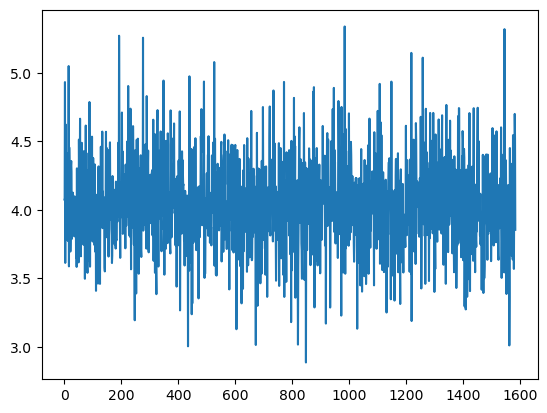

In [210]:
plt.plot(model.predict(X_test))

In [30]:
import sklearn
sklearn.__version__

'1.2.2'